# CODING CHALLENGE – DATA SCIENTIST
- Prediction of cost per time
- Price for customer


In [1]:
import arff 
import statsmodels.api as sm
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

1. Load datasets
2. Convert to pandas DataFrame
3. Merge datasets


In [2]:
pd.set_option('display.max_columns', None)

folder_data = 'Raw_data/'
data_freq = arff.load(folder_data+'freMTPL2freq.arff') 
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]) 
data_sev = arff.load(folder_data+'freMTPL2sev.arff') 
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"]) 

df_data = pd.merge(df_freq, df_sev, on='IDpol', how='inner') 

1. Check for missing numbers
2. Optional: Drop missing values

In [3]:
#print(df_data.describe)
print(df_data.isna().sum())
#df_data = df_data.dropnan()

IDpol          0
ClaimNb        0
Exposure       0
Area           0
VehPower       0
VehAge         0
DrivAge        0
BonusMalus     0
VehBrand       0
VehGas         0
Density        0
Region         0
ClaimAmount    0
dtype: int64


1. Calculate target value `ClaimAmout_Exposure`
2. Exclude ID from dataset dfID
3. Generate feature matrix X_df
4. Generate target vector using 'ln' transformation y_true_ln

In [4]:
df_data['ClaimAmout_Exposure'] = df_data['ClaimAmount'] / df_data['Exposure']
df_ID = pd.DataFrame(df_data['IDpol'])
df_data = df_data.drop(columns=['ClaimAmount'])
df_data = df_data.drop(columns=['IDpol'])
y_df = df_data['ClaimAmout_Exposure']
y_true_ln = np.log(y_df+1)
X_df = df_data.drop(columns=['ClaimAmout_Exposure']) 

### Visualize distribution of target value and features

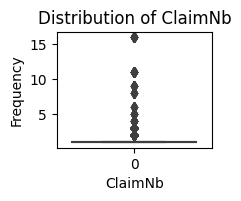

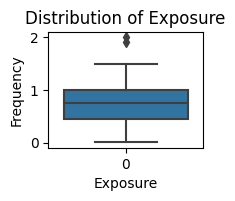

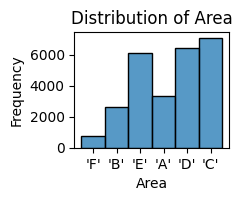

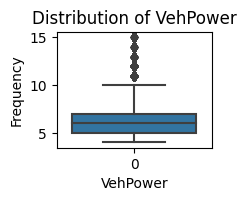

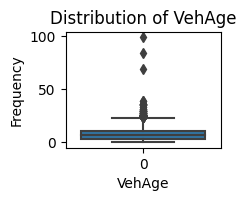

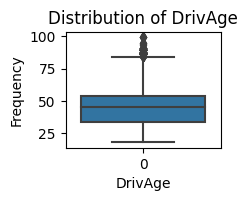

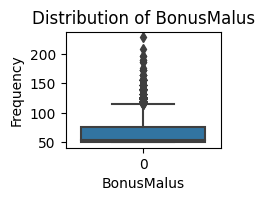

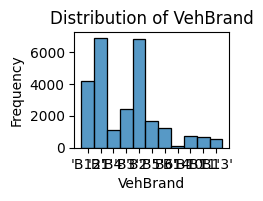

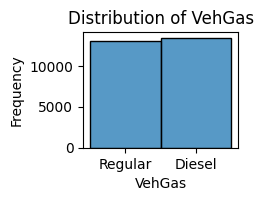

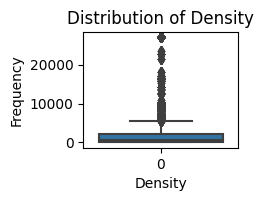

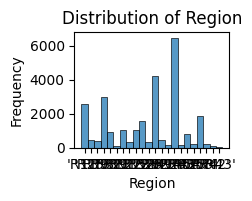

In [5]:
columns = X_df.columns
numeric_columns = X_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = [col for col in columns if col not in numeric_columns]

for col in columns:
    plt.figure(figsize=(2, 1.5)) 
    
    if col in numeric_columns:
        sns.boxplot(df_data[col])
    else:
        sns.histplot(df_data[col])  
    plt.title('Distribution of {}'.format(col))
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### QQ-plot

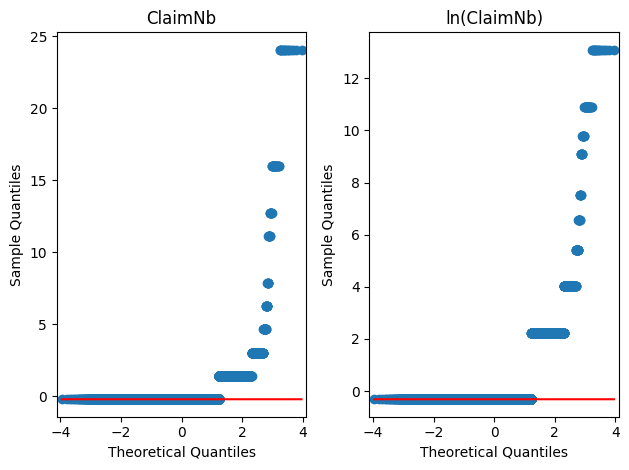

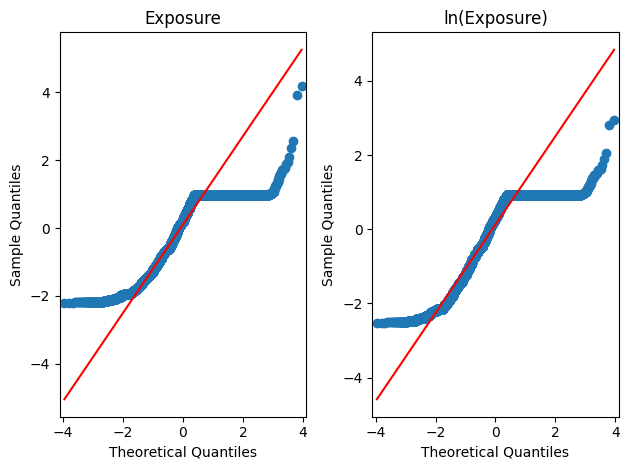

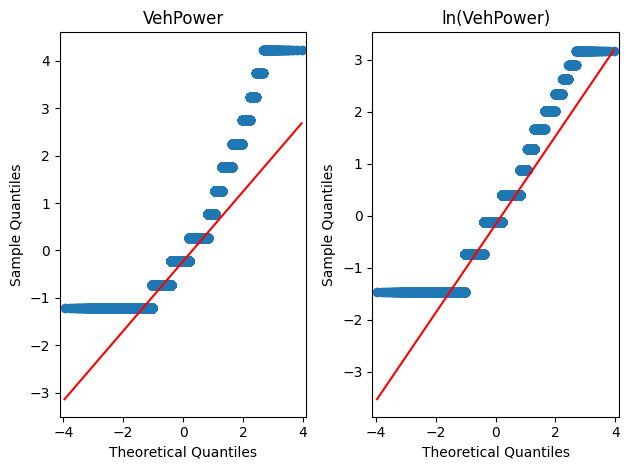

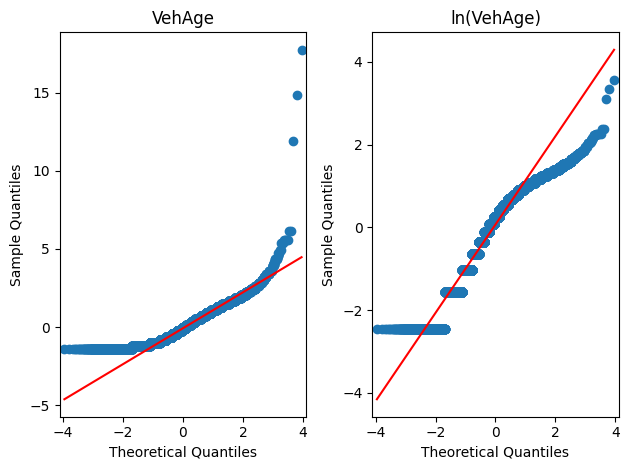

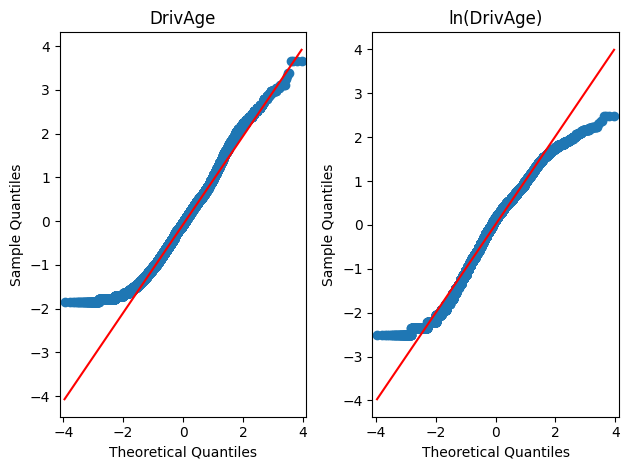

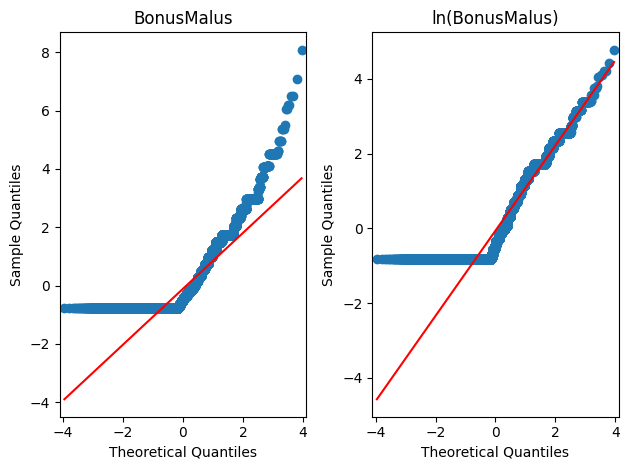

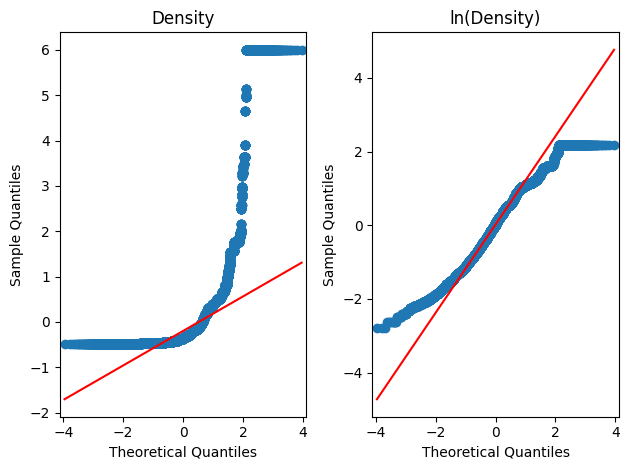

In [6]:
for col in numeric_columns:
    y = df_data[col]
    y_log = np.log(y+1)
    y_norm = (y - y.mean()) / y.std(ddof=1)
    y_log_norm = (y_log - y_log.mean()) / y_log.std(ddof=1)
    
    fig = sm.qqplot(y_norm, line='q', ax=plt.subplot(1, 2, 1))
    plt.title(col) 
    
    fig = sm.qqplot(y_log_norm, line='q', ax=plt.subplot(1, 2, 2))
    plt.title('ln({})'.format(col))
    plt.tight_layout()
    plt.show()

### Trandormation: ln

In [8]:
df_log = pd.DataFrame()
for col in numeric_columns:
    y = df_data[col]
    y_log = np.log(y+1)
    y_log_norm = (y_log - y_log.mean()) / y_log.std(ddof=1)
    df_log[col] = y_log_norm

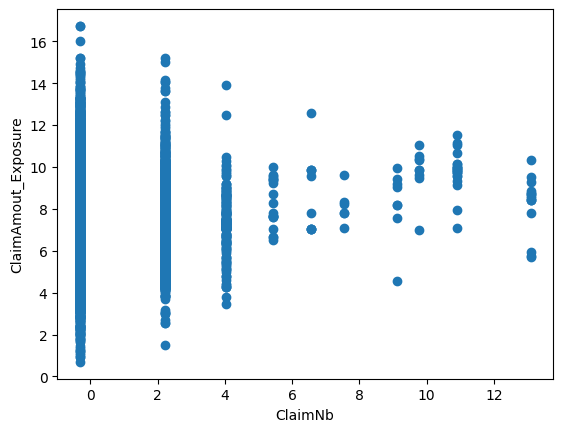

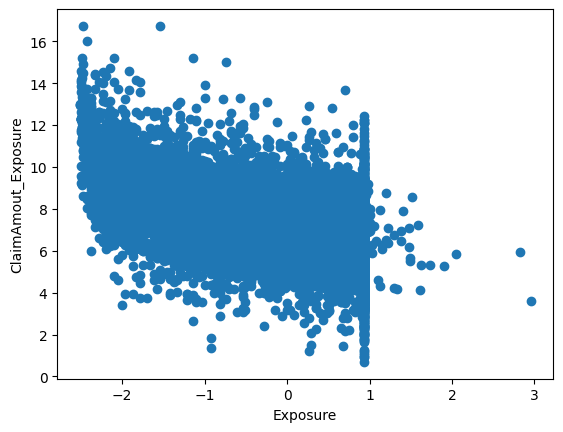

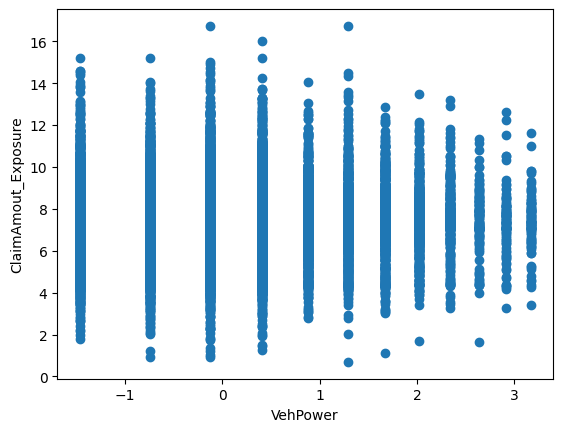

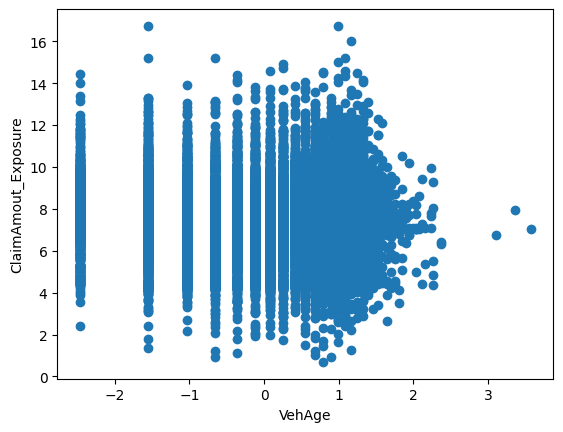

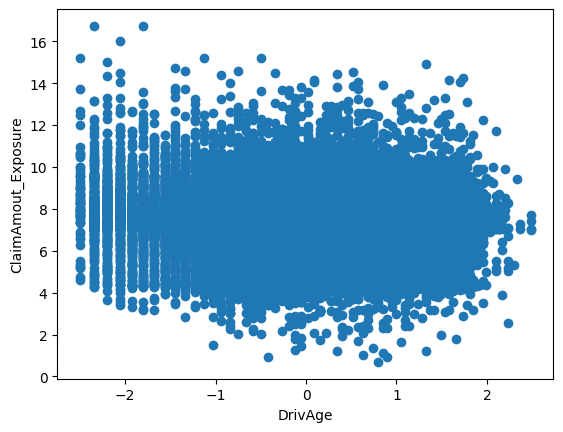

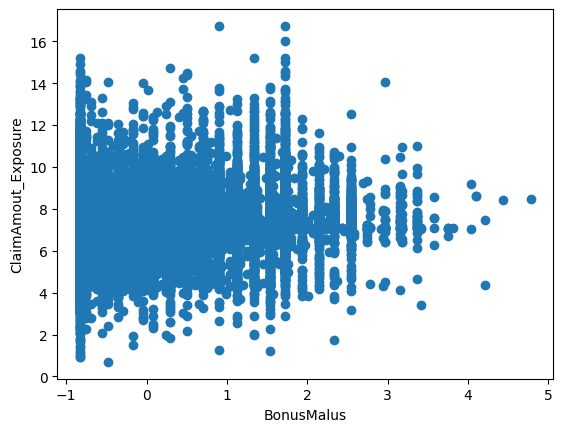

In [9]:
features = df_log.columns
for feature in features[:-1]:
    plt.plot(df_log[feature], y_true_ln, 'o')
    plt.xlabel(feature)
    plt.ylabel('ClaimAmout_Exposure')  
    plt.show()

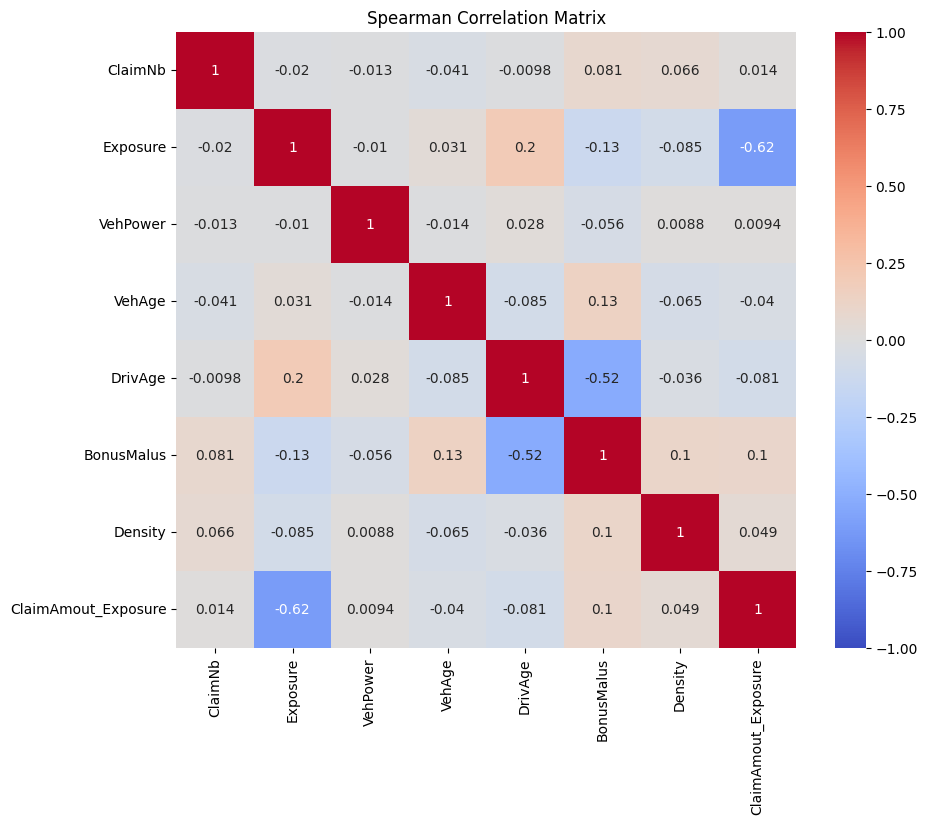

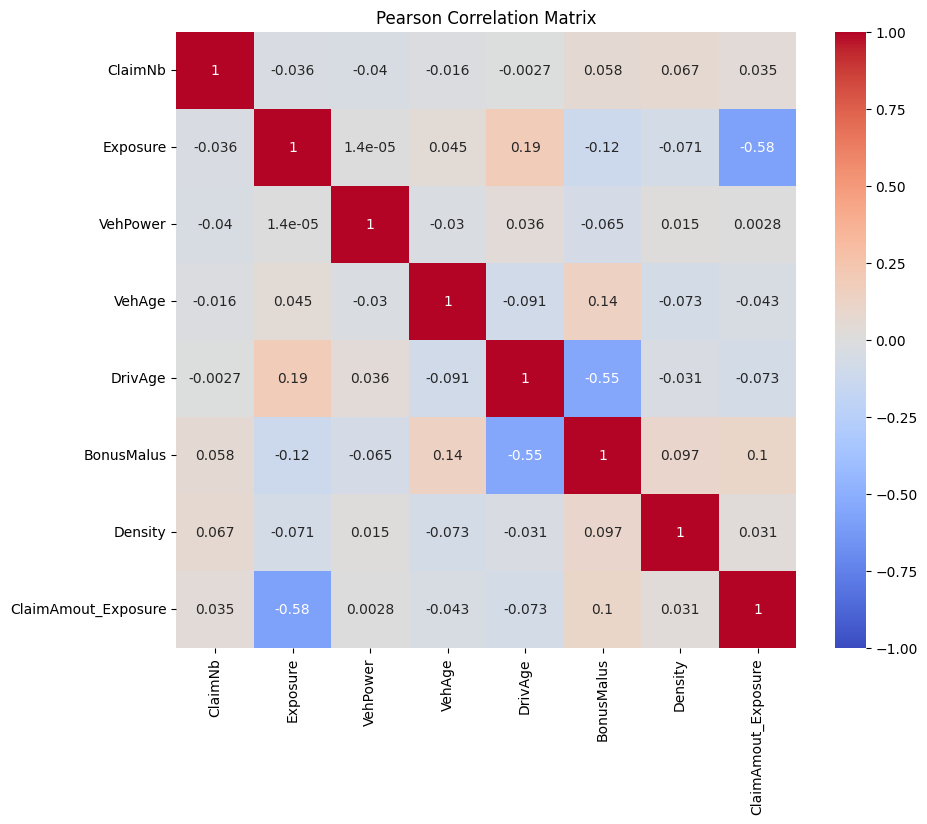

In [10]:
X_y_log = pd.concat([df_log, y_true_ln], axis=1)
corr_matrix = X_y_log.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix')
plt.show()

corr_matrix = X_y_log.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix')
plt.show()

### One-hot encoding
1. Transformation of categorical variables into numerical values [0,1]

In [11]:
for cat_feature in categorical_columns:
    print('{}:{}'.format(cat_feature, X_df[cat_feature].unique()))

df_encoded = pd.get_dummies(X_df, columns=categorical_columns, dtype=int)
df_encoded = df_encoded[df_encoded.columns[len(df_log.columns):]]

df_log_one_hot = pd.concat([df_encoded, df_log], axis=1)
features = df_log_one_hot.columns

cat_features = df_encoded.columns

Area:["'F'" "'B'" "'E'" "'A'" "'D'" "'C'"]
VehBrand:["'B12'" "'B1'" "'B4'" "'B3'" "'B2'" "'B5'" "'B6'" "'B14'" "'B10'" "'B11'"
 "'B13'"]
VehGas:['Regular' 'Diesel']
Region:["'R11'" "'R25'" "'R73'" "'R93'" "'R31'" "'R21'" "'R91'" "'R22'" "'R72'"
 "'R52'" "'R26'" "'R82'" "'R41'" "'R94'" "'R24'" "'R83'" "'R54'" "'R23'"
 "'R53'" "'R74'" "'R42'" "'R43'"]


### Mean Absolute Error
1. Easy to interpret: Same units as target units
2. Robust to outliers

In [12]:
from sklearn.ensemble import RandomForestRegressor
def fun_MAE(Y_exp, Y_calc):
    '''
    Calculates the Mean absolute error.
    MAE = ||y_exp - y_calc|| / n

    Parameters
    ----------
    y_exp : numpy array (n x 1)
    y_calc : numpy array (n x 1)

    Returns
    -------
    MAE : float

    '''
    n = Y_exp.shape[0]
    AE = np.abs(Y_exp - Y_calc).sum() 
    MAE = AE / n
    return (MAE)

### Train Random Forest Regressor
1. Setting numpy seed for reproducibility
2. Train and test splitting, since a test distribution shall be simulated
3. Check number of values per categorical variable
4. Random Forest Regressor
5. - Non-linear relationships
   - Robust to train
   - Robust to overfitting: Bootstrap Aggregation
   - -Each forest has a subset of the data
   - -Subset of features

In [13]:
np.random.seed(42)
rand_index = np.random.permutation([i for i in range(df_log_one_hot.shape[0])])
index_test = rand_index[-int(1/5*rand_index.shape[0]):]
index_train = rand_index[:-int(1/5*rand_index.shape[0])]
features = df_log_one_hot.columns

X_test = np.array(df_log_one_hot)[index_test]
y_true_test = np.array(y_true_ln)[index_test]

X_train = np.array(df_log_one_hot)[index_train]
y_true_train = np.array(y_true_ln)[index_train]

for n, cat_feature in enumerate(cat_features):
    print('{}: {}'.format(cat_feature, X_train[:,n].sum()))

Area_'A': 2718.0
Area_'B': 2060.0
Area_'C': 5689.0
Area_'D': 5136.0
Area_'E': 4941.0
Area_'F': 612.0
VehBrand_'B1': 5517.0
VehBrand_'B10': 603.0
VehBrand_'B11': 530.0
VehBrand_'B12': 3342.0
VehBrand_'B13': 430.0
VehBrand_'B14': 106.0
VehBrand_'B2': 5432.0
VehBrand_'B3': 1985.0
VehBrand_'B4': 874.0
VehBrand_'B5': 1333.0
VehBrand_'B6': 1004.0
VehGas_Diesel: 10751.0
VehGas_Regular: 10405.0
Region_'R11': 2079.0
Region_'R21': 66.0
Region_'R22': 236.0
Region_'R23': 186.0
Region_'R24': 5165.0
Region_'R25': 359.0
Region_'R26': 282.0
Region_'R31': 771.0
Region_'R41': 357.0
Region_'R42': 76.0
Region_'R43': 28.0
Region_'R52': 1259.0
Region_'R53': 1504.0
Region_'R54': 626.0
Region_'R72': 858.0
Region_'R73': 296.0
Region_'R74': 156.0
Region_'R82': 3356.0
Region_'R83': 119.0
Region_'R91': 854.0
Region_'R93': 2418.0
Region_'R94': 105.0


In [14]:
rf_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=1.0, criterion='absolute_error', random_state=42)
rf_reg.fit(X_train, y_true_train)

y_calc_train = rf_reg.predict(X_train)
y_calc_test = rf_reg.predict(X_test)

MAE_train = fun_MAE(np.exp(y_true_train), np.exp(y_calc_train))
MAE_test = fun_MAE(np.exp(y_true_test), np.exp(y_calc_test))
print('Train: MAE : {:.4g}'.format(MAE_train))
print('Test: MAE : {:.4g}'.format(MAE_test))

Train: MAE : 5956
Test: MAE : 5846


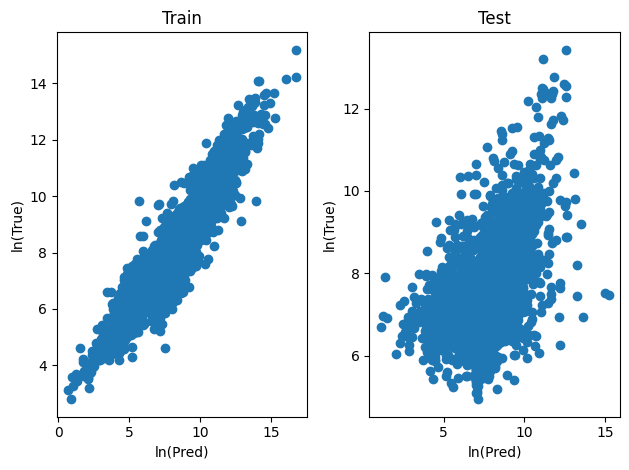

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].plot(y_true_train, y_calc_train ,'o')
ax[0].set_xlabel('ln(Pred)')
ax[0].set_ylabel('ln(True)')
ax[0].set_title('Train')
ax[1].plot(y_true_test, y_calc_test ,'o')
ax[1].set_xlabel('ln(Pred)')
ax[1].set_ylabel('ln(True)')
ax[1].set_title('Test')
plt.tight_layout()
plt.show()

In [16]:
def fun_relative_deviation (y_exp, y_calc, epsilon = 1E-8):
    '''
    Calculates the Sum of Relative Deviation (SRD). For experimental data 
    containing "0", the relative deviation (RD) is set to "0".
    '''
    bigger_zero = y_exp > epsilon
    smaller_zero = y_exp < -epsilon
    non_zero = np.logical_or(smaller_zero, bigger_zero)
    RD = np.zeros(y_exp.shape)    
    RD[non_zero] = np.abs(y_exp[non_zero] - y_calc[non_zero]) / np.abs(y_exp[non_zero])
    SRD = RD.sum()
    return (SRD)

def fun_ARD (Y_exp, Y_calc, epsilon=1E-8):
    '''
    Calculates the Average Relative Deviation of the Experimental Data and the 
    fitted Data and returns it. 
    '''
    datapoints = Y_exp.shape[0]    
    RD_sum = fun_relative_deviation(Y_exp, Y_calc, epsilon)   	  
    ARD = RD_sum / datapoints
    return (ARD) 

In [17]:
y_true_train_exp = np.exp(y_true_train)
y_calc_train_exp = np.exp(y_calc_train)

y_true_test_exp = np.exp(y_true_test)
y_calc_test_exp = np.exp(y_calc_test)

ARD_train = fun_ARD(y_true_train_exp, y_calc_train_exp)
ARD_test = fun_ARD(y_true_test_exp, y_calc_test_exp)

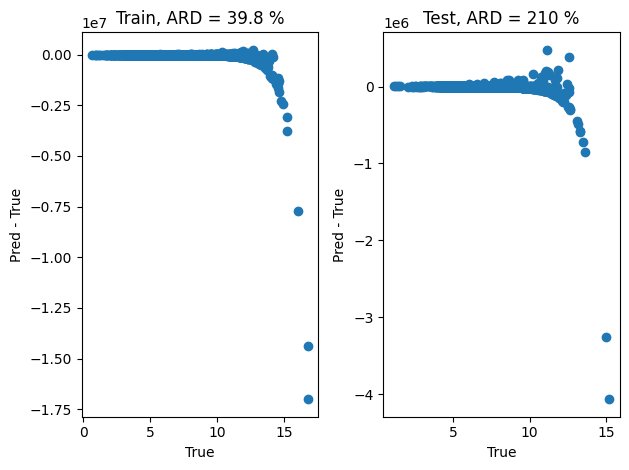

In [18]:
fig, ax = plt.subplots(1,2)
ax[0].plot(np.log(y_true_train_exp), y_calc_train_exp-y_true_train_exp, 'o')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Pred - True')
ax[0].set_title('Train, ARD = {:.3g} %'.format(ARD_train*100))
ax[1].plot(np.log(y_true_test_exp), y_calc_test_exp-y_true_test_exp,'o')
ax[1].set_xlabel('True')
ax[1].set_ylabel('Pred - True')
ax[1].set_title('Test, ARD = {:.3g} %'.format(ARD_test*100))
plt.tight_layout()
plt.show()

### Feature Importance
- Exposure: Länge des Versicherungszeitraums
- Density: Anzahl der Einwohner pro km2 im Wohnort des Versicherungsnehmers
- DrivAge: Alter des Versicherungsnehmers
- VehAge: Alter des versicherten Kfz
- VehPower: Leistung des versicherten Kfz
- BonusMalus: Schadenfreiheitsrabatt

In [19]:
rf_reg_feature_importances = rf_reg.feature_importances_
features_importance_dict = dict(zip(features, rf_reg_feature_importances))

sorted_features_importance = dict(sorted(features_importance_dict.items(), key=lambda x: x[1], reverse=True))

for feature in sorted_features_importance.keys():
    value = sorted_features_importance[feature]
    print('{}: {:.3g}'.format(feature, value))


Exposure: 0.34
Density: 0.106
DrivAge: 0.102
VehAge: 0.0828
VehPower: 0.0551
BonusMalus: 0.0509
VehBrand_'B2': 0.0134
VehBrand_'B1': 0.0134
VehGas_Regular: 0.0117
Region_'R82': 0.0117
ClaimNb: 0.0116
VehGas_Diesel: 0.0115
Region_'R24': 0.0114
Region_'R93': 0.0114
Area_'D': 0.0106
VehBrand_'B3': 0.0102
Area_'C': 0.0101
VehBrand_'B5': 0.00932
Region_'R53': 0.0081
Region_'R52': 0.00756
Area_'E': 0.00721
VehBrand_'B6': 0.00719
VehBrand_'B4': 0.00677
Area_'B': 0.00676
Region_'R72': 0.00651
Region_'R11': 0.00628
Region_'R31': 0.00625
VehBrand_'B12': 0.00577
Region_'R91': 0.00546
Region_'R54': 0.00523
VehBrand_'B10': 0.00518
VehBrand_'B11': 0.00485
VehBrand_'B13': 0.00477
Area_'A': 0.00406
Region_'R25': 0.00396
Region_'R41': 0.00369
Region_'R73': 0.00313
Region_'R26': 0.00287
Region_'R22': 0.00279
Region_'R23': 0.00224
Region_'R74': 0.00171
Area_'F': 0.0015
VehBrand_'B14': 0.00144
Region_'R83': 0.00141
Region_'R94': 0.00125
Region_'R21': 0.00124
Region_'R42': 0.00109
Region_'R43': 0.000504


### Cross-validation and hyperparameter tuning
1. max_depth: Number of branches in the tree
2. min_samples_split: Minimum number of samples required for solving
3. min_samples_leaf: Minimum number of samples required at a leaf node
4. max_features: Number of features considered for splitting at each node

--> Random grid search